
Evaluating STING clustering for Car Data
Processing grid_size: 5
  threshold: 0.0010, clusters: 10, silhouette: 0.0212
  threshold: 0.0036, clusters: 10, silhouette: 0.0212
  threshold: 0.0062, clusters: 9, silhouette: 0.0210
  threshold: 0.0087, clusters: 8, silhouette: 0.0241
  threshold: 0.0113, clusters: 7, silhouette: 0.0254
  threshold: 0.0139, clusters: 7, silhouette: 0.0254
  threshold: 0.0165, clusters: 7, silhouette: 0.0254
  threshold: 0.0191, clusters: 7, silhouette: 0.0254
  threshold: 0.0216, clusters: 7, silhouette: 0.0254
  threshold: 0.0242, clusters: 6, silhouette: 0.0394
  threshold: 0.0268, clusters: 6, silhouette: 0.0394
  threshold: 0.0294, clusters: 6, silhouette: 0.0394
  threshold: 0.0319, clusters: 6, silhouette: 0.0394
  threshold: 0.0345, clusters: 6, silhouette: 0.0394
  threshold: 0.0371, clusters: 6, silhouette: 0.0394
  threshold: 0.0397, clusters: 6, silhouette: 0.0394
  threshold: 0.0423, clusters: 6, silhouette: 0.0394
  threshold: 0.0448, clusters: 

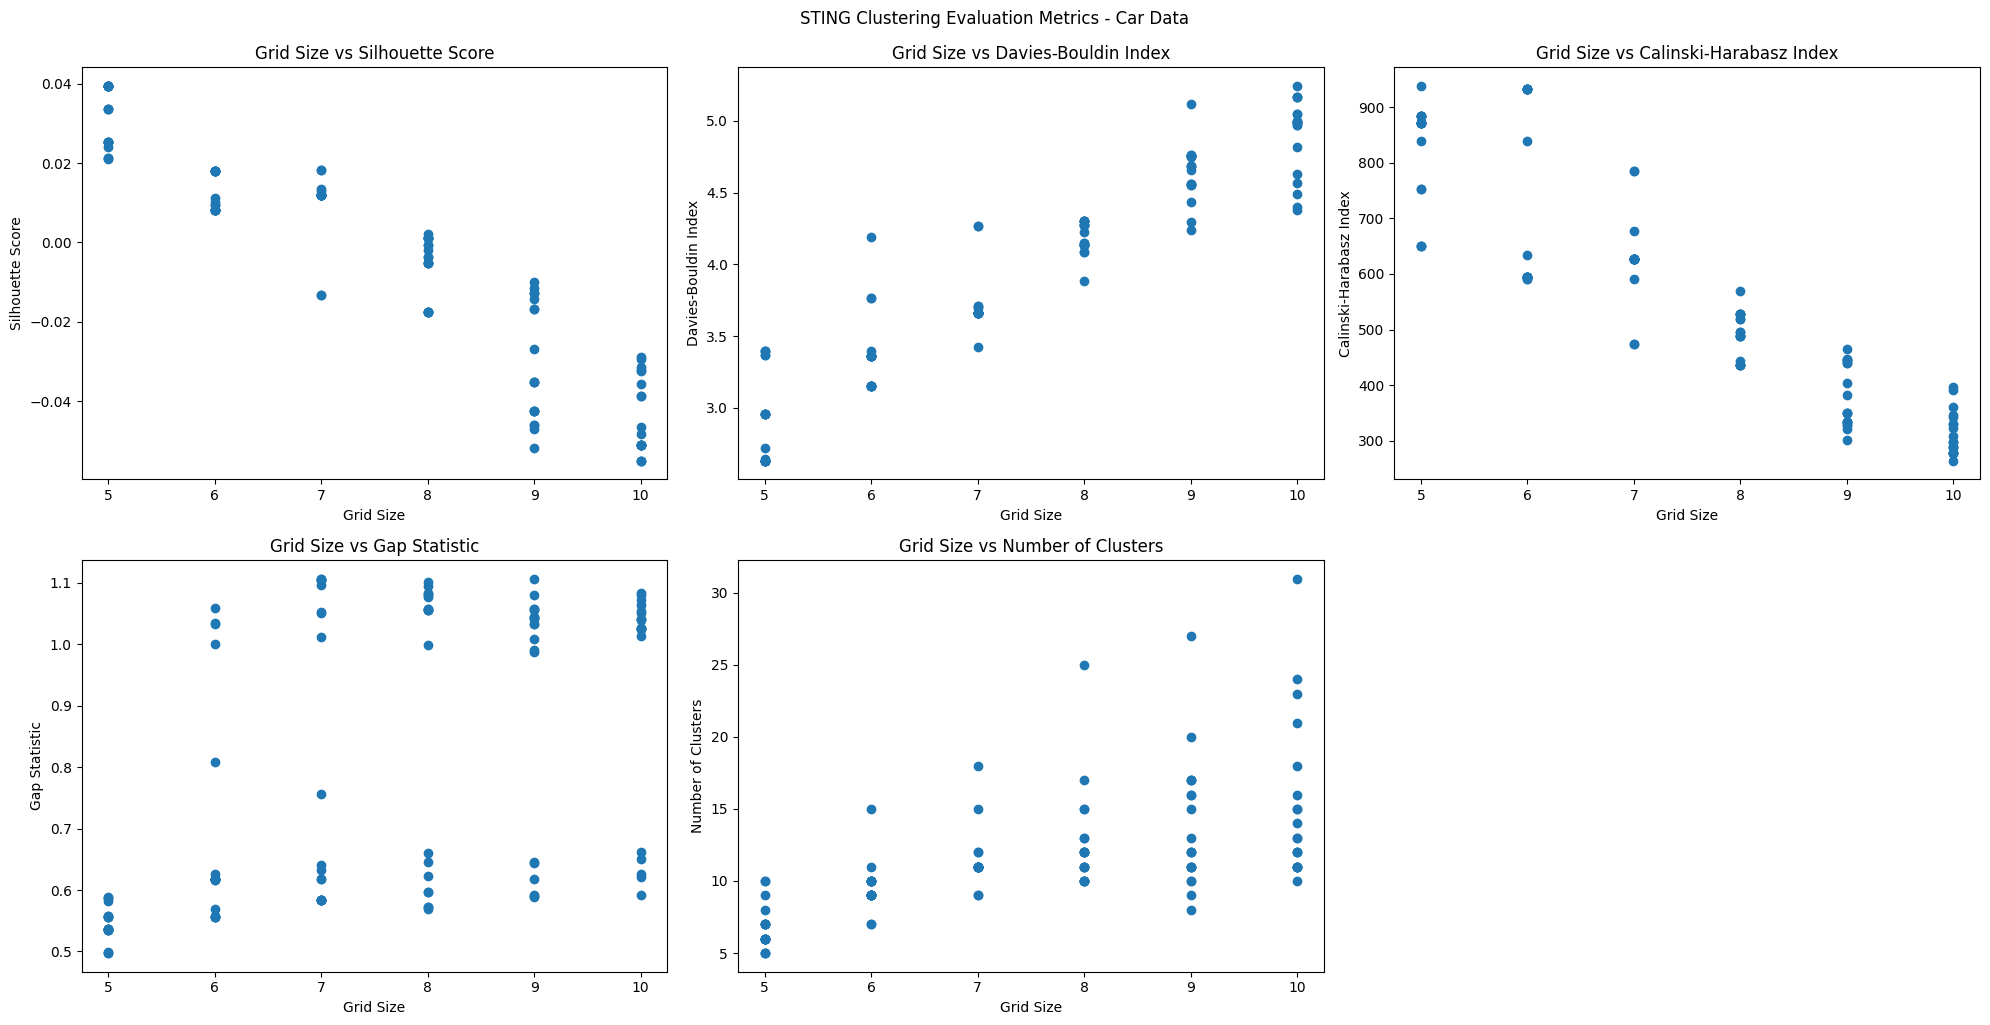

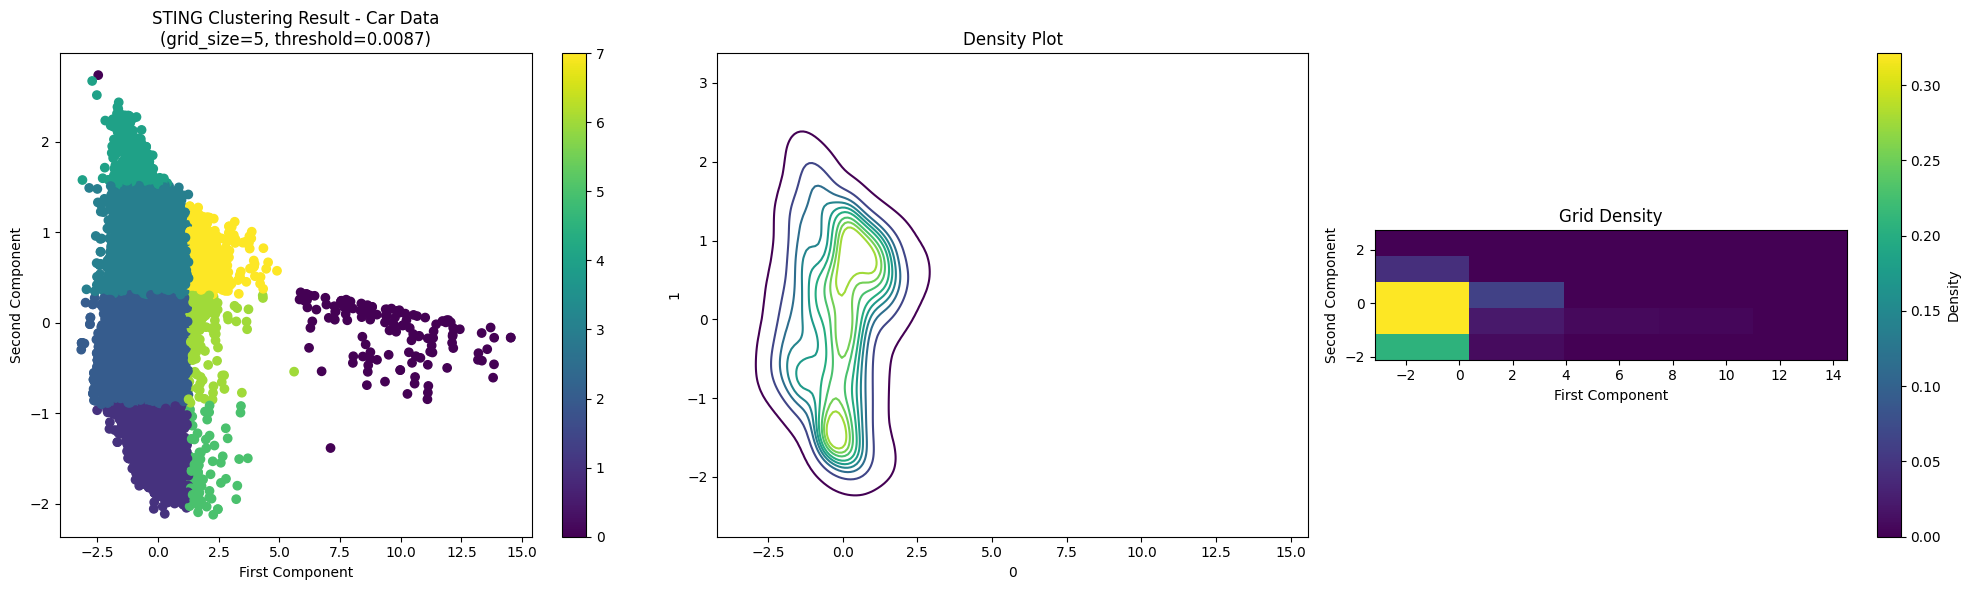

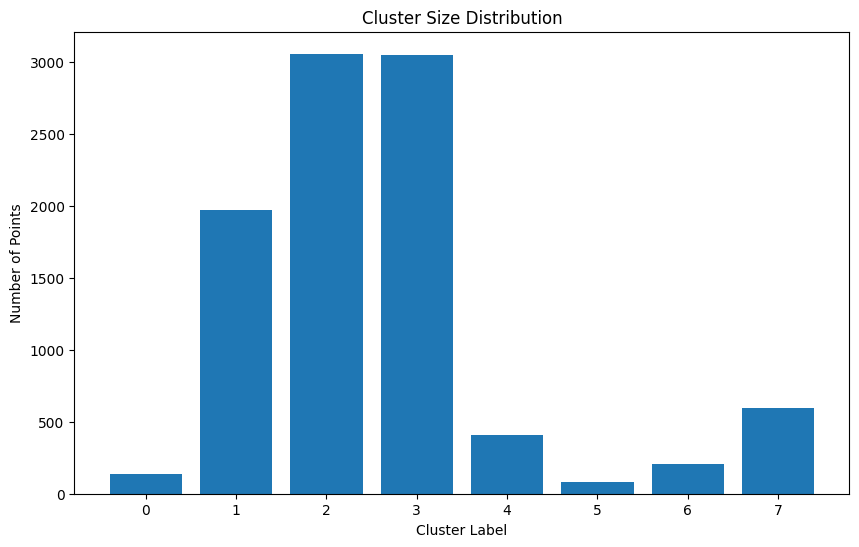


Best parameters for Car Data:
Grid size: 5
Threshold: 0.0087
Number of clusters: 8

Validation metrics:
Silhouette Score: 0.0241
Davies-Bouldin Index: 2.7231
Calinski-Harabasz Index: 937.9424
Gap Statistic: 0.5826

Evaluating STING clustering for Customer Data
Processing grid_size: 5
  threshold: 0.0010, clusters: 15, silhouette: 0.0808
  threshold: 0.0036, clusters: 15, silhouette: 0.0808
  threshold: 0.0062, clusters: 15, silhouette: 0.0808
  threshold: 0.0087, clusters: 15, silhouette: 0.0808
  threshold: 0.0113, clusters: 15, silhouette: 0.0808
  threshold: 0.0139, clusters: 15, silhouette: 0.0808
  threshold: 0.0165, clusters: 14, silhouette: 0.0834
  threshold: 0.0191, clusters: 14, silhouette: 0.0834
  threshold: 0.0216, clusters: 12, silhouette: 0.0797
  threshold: 0.0242, clusters: 12, silhouette: 0.0797
  threshold: 0.0268, clusters: 12, silhouette: 0.0797
  threshold: 0.0294, clusters: 12, silhouette: 0.0797
  threshold: 0.0319, clusters: 11, silhouette: 0.0781
  threshold:

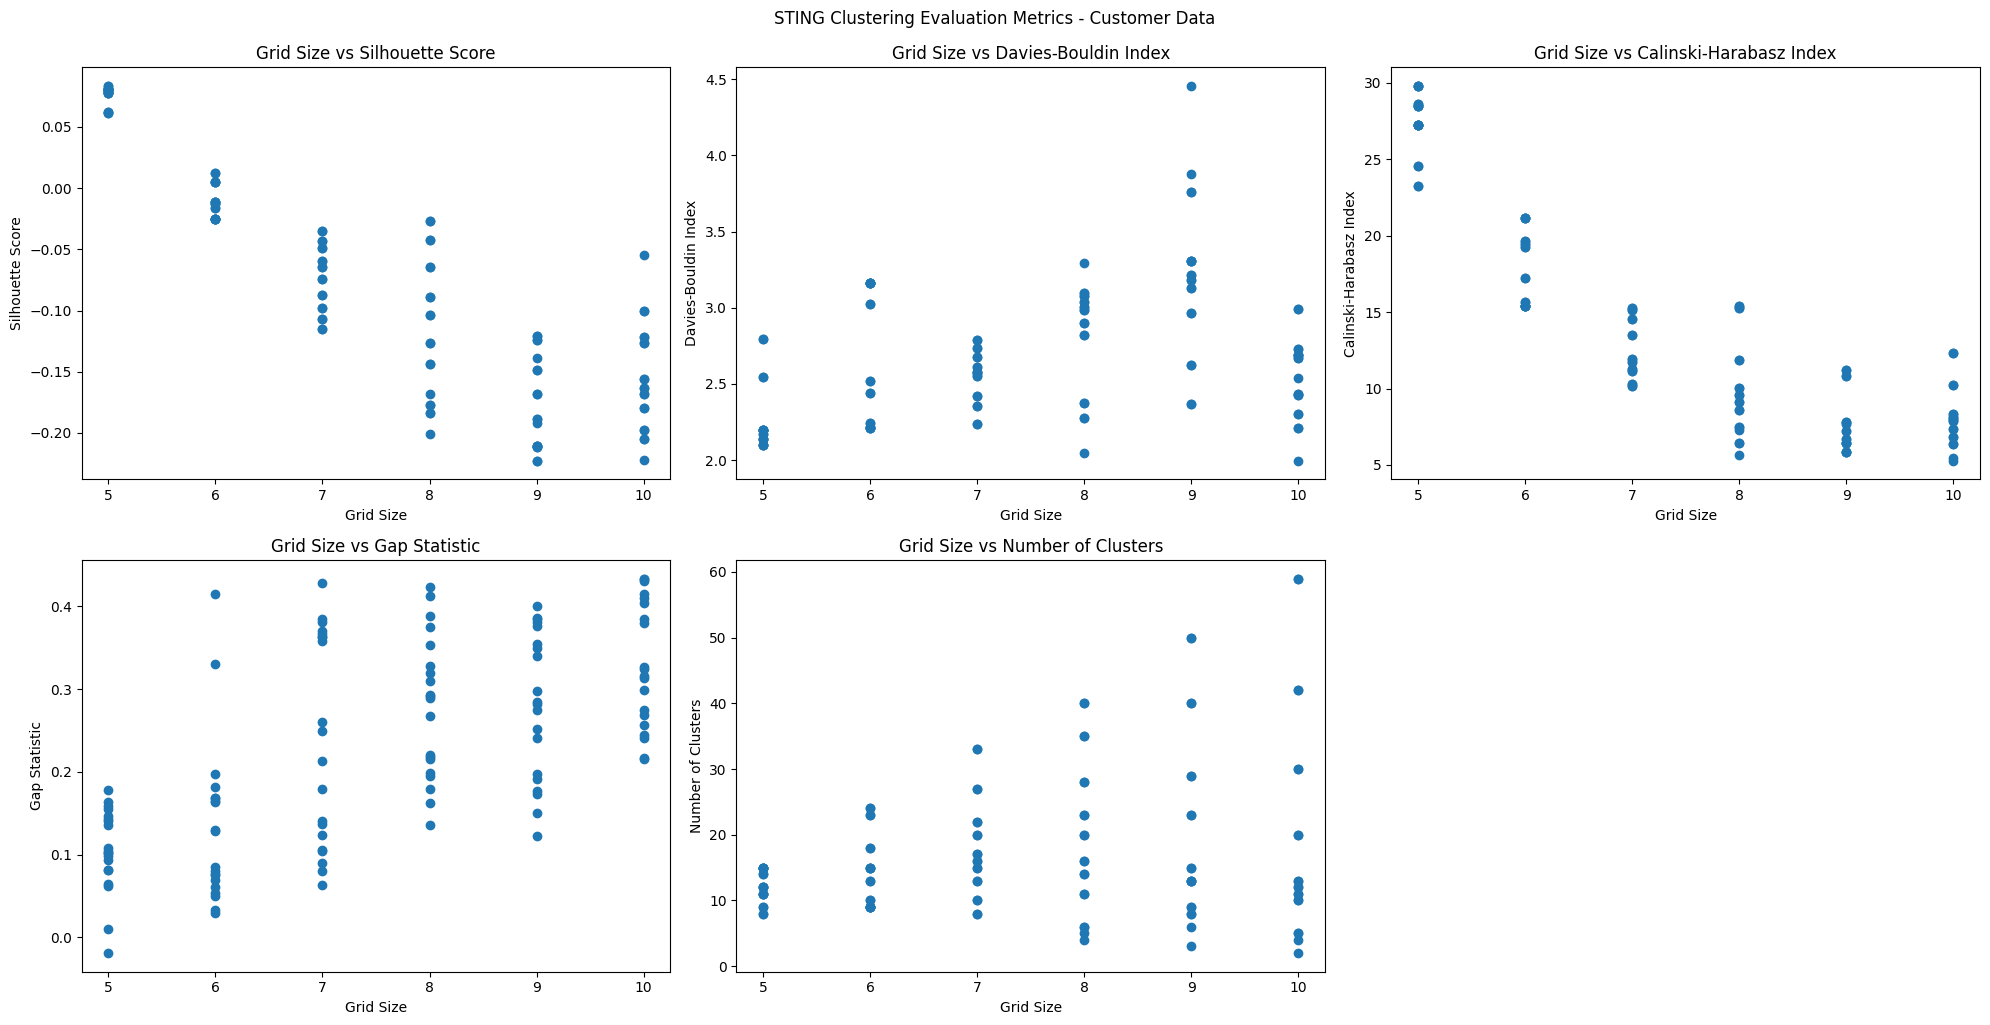

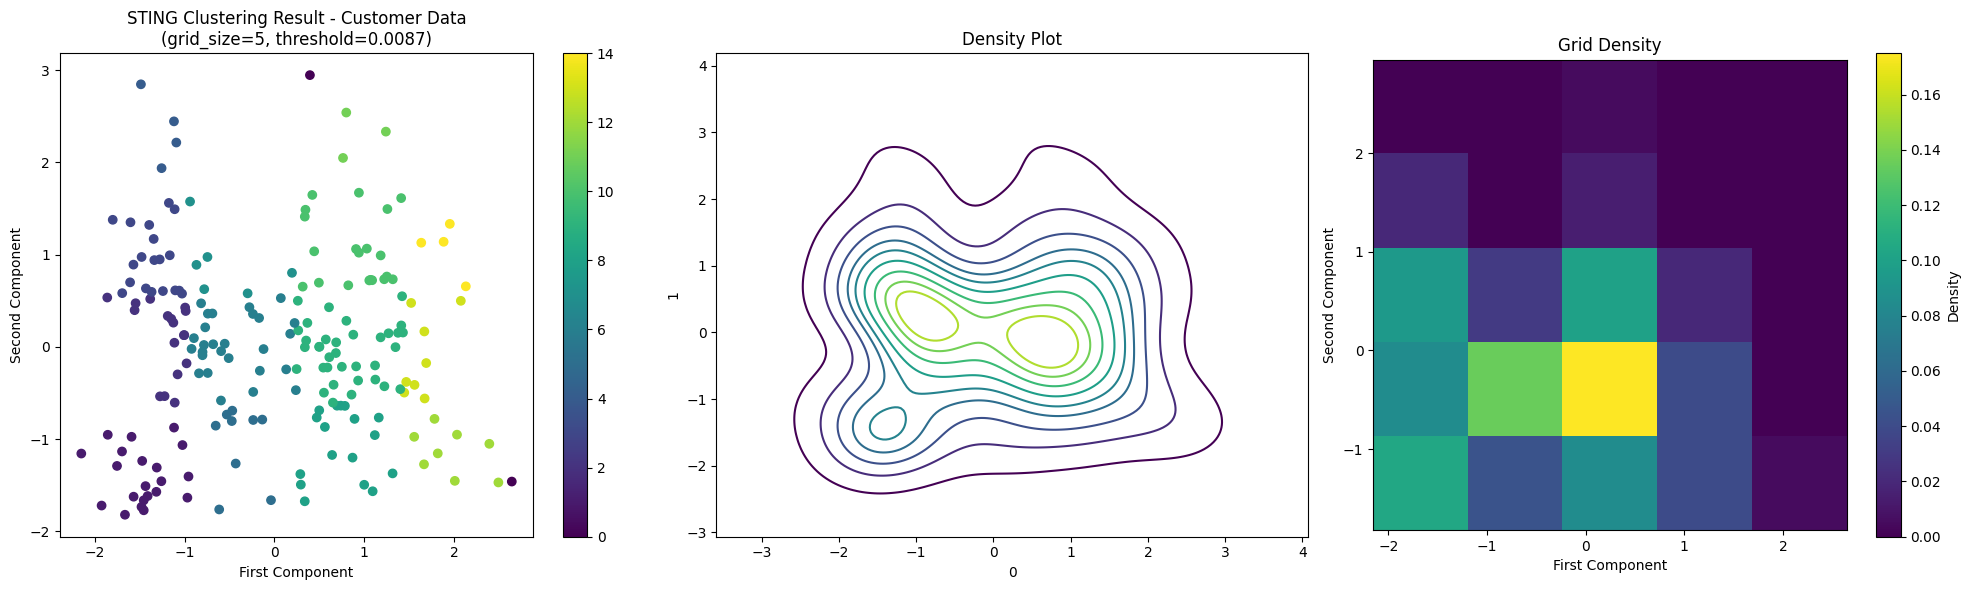

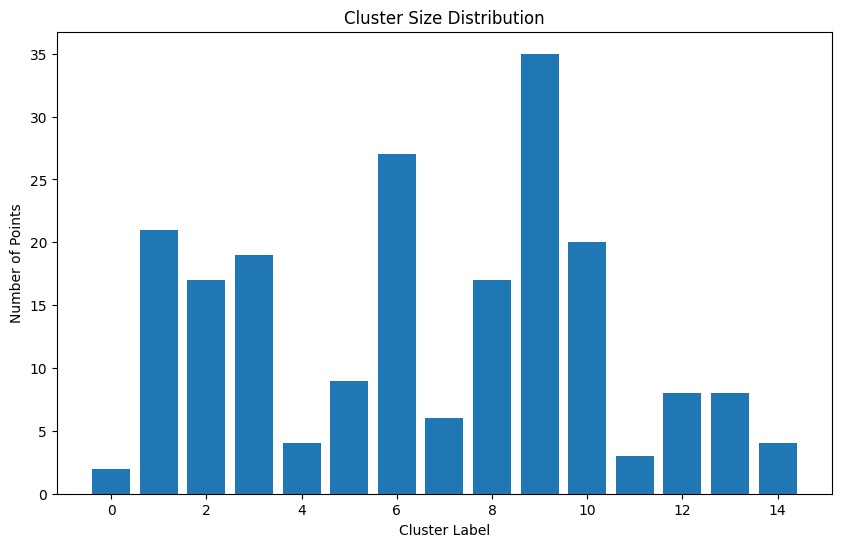


Best parameters for Customer Data:
Grid size: 5
Threshold: 0.0087
Number of clusters: 15

Validation metrics:
Silhouette Score: 0.0808
Davies-Bouldin Index: 2.1990
Calinski-Harabasz Index: 27.2132
Gap Statistic: 0.1778


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy import stats

class STINGClustering:
    
    def __init__(self, grid_size=10, threshold=0.01):
        self.grid_size = grid_size
        self.threshold = threshold
        self.grid = None
        self.cluster_labels = None
        
    def fit_predict(self, data, metric='euclidean'):
 
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)

        x_min, x_max = scaled_data[:, 0].min(), scaled_data[:, 0].max()
        y_min, y_max = scaled_data[:, 1].min(), scaled_data[:, 1].max()
        
        x_grid = np.linspace(x_min, x_max, self.grid_size)
        y_grid = np.linspace(y_min, y_max, self.grid_size)
        
        self.grid = np.zeros((self.grid_size, self.grid_size))

        for i in range(len(scaled_data)):
            x_idx = np.digitize(scaled_data[i, 0], x_grid) - 1
            y_idx = np.digitize(scaled_data[i, 1], y_grid) - 1
            self.grid[x_idx, y_idx] += 1
            

        self.grid = self.grid / len(scaled_data)

        high_density = self.grid > self.threshold
        

        labels = np.zeros(len(scaled_data))
        current_cluster = 0
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if high_density[i, j]:
                    current_cluster += 1
                    x_start, x_end = x_grid[i], x_grid[min(i+1, self.grid_size-1)]
                    y_start, y_end = y_grid[j], y_grid[min(j+1, self.grid_size-1)]
                    
                
                    mask = ((scaled_data[:, 0] >= x_start) & 
                           (scaled_data[:, 0] < x_end) & 
                           (scaled_data[:, 1] >= y_start) & 
                           (scaled_data[:, 1] < y_end))
                    
                    labels[mask] = current_cluster
                    
        self.cluster_labels = labels
        return labels

def evaluate_sting(data, param_grid, name=""):

    
    results = []
    
    def compute_gap_statistic(data, labels, grid_size, threshold, n_refs=5):
        ref_dispersions = []
        for i in range(n_refs):
            ref_data = np.random.uniform(
                data.min(axis=0),
                data.max(axis=0),
                size=data.shape
            )
            ref_sting = STINGClustering(
                grid_size=grid_size,
                threshold=threshold
            )
            ref_labels = ref_sting.fit_predict(ref_data)
            ref_dispersions.append(np.log(compute_dispersion(ref_data, ref_labels)))
            
        actual_dispersion = np.log(compute_dispersion(data, labels))
        gap = np.mean(ref_dispersions) - actual_dispersion
        return gap
    
    def compute_dispersion(data, labels):
        unique_labels = np.unique(labels)
        total_dispersion = 0
        for label in unique_labels:
            if label != -1:  
                cluster_points = data[labels == label]
                if len(cluster_points) > 1:
                    centroid = cluster_points.mean(axis=0)
                    dispersion = np.sum(cdist([centroid], cluster_points)[0])
                    total_dispersion += dispersion
        return total_dispersion

    for grid_size in param_grid['grid_size']:
        print(f"Processing grid_size: {grid_size}")
        for threshold in param_grid['threshold']:
            sting = STINGClustering(grid_size=grid_size, threshold=threshold)
            try:
                labels = sting.fit_predict(data)
                
                n_clusters = len(np.unique(labels))
                if n_clusters < 2 or n_clusters > len(data) * 0.5:
                    continue
                    
                silhouette = silhouette_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)
                gap = compute_gap_statistic(data, labels, grid_size, threshold)
                
                results.append({
                    'grid_size': grid_size,
                    'threshold': threshold,
                    'n_clusters': n_clusters,
                    'silhouette': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski_harabasz,
                    'gap_statistic': gap
                })
                
                print(f"  threshold: {threshold:.4f}, clusters: {n_clusters}, "
                      f"silhouette: {silhouette:.4f}")
                
            except Exception as e:
                print(f"Error with grid_size={grid_size}, threshold={threshold}: {str(e)}")
                continue
    
    if not results:
        raise ValueError("No valid clustering results found. Try adjusting parameter ranges.")
    
    results_df = pd.DataFrame(results)
    
    results_df['combined_score'] = (
        results_df['silhouette'] 
        - results_df['davies_bouldin'] / results_df['davies_bouldin'].max()
        + results_df['calinski_harabasz'] / results_df['calinski_harabasz'].max()
        + results_df['gap_statistic'] / results_df['gap_statistic'].max()
    )
    
    best_result = results_df.loc[results_df['combined_score'].idxmax()]
    
    plot_evaluation_metrics(results_df, name)
    
    best_sting = STINGClustering(
        grid_size=int(best_result['grid_size']),
        threshold=best_result['threshold']
    )
    final_labels = best_sting.fit_predict(data)
    
    plot_clustering_results(data, final_labels, best_result, name, best_sting.grid)
    
    return best_result, final_labels

def plot_evaluation_metrics(results_df, name):
    plt.figure(figsize=(20, 10))
    
    # Silhouette Score
    plt.subplot(231)
    plt.scatter(results_df['grid_size'], results_df['silhouette'])
    plt.xlabel('Grid Size')
    plt.ylabel('Silhouette Score')
    plt.title('Grid Size vs Silhouette Score')
    
    # Davies-Bouldin Index
    plt.subplot(232)
    plt.scatter(results_df['grid_size'], results_df['davies_bouldin'])
    plt.xlabel('Grid Size')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Grid Size vs Davies-Bouldin Index')
    
    # Calinski-Harabasz Index
    plt.subplot(233)
    plt.scatter(results_df['grid_size'], results_df['calinski_harabasz'])
    plt.xlabel('Grid Size')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title('Grid Size vs Calinski-Harabasz Index')
    
    # Gap Statistic
    plt.subplot(234)
    plt.scatter(results_df['grid_size'], results_df['gap_statistic'])
    plt.xlabel('Grid Size')
    plt.ylabel('Gap Statistic')
    plt.title('Grid Size vs Gap Statistic')
    
    # Number of Clusters
    plt.subplot(235)
    plt.scatter(results_df['grid_size'], results_df['n_clusters'])
    plt.xlabel('Grid Size')
    plt.ylabel('Number of Clusters')
    plt.title('Grid Size vs Number of Clusters')
    
    plt.tight_layout()
    plt.suptitle(f'STING Clustering Evaluation Metrics - {name}', y=1.02)
    plt.savefig(f'figs/sting_evaluation_metrics_{name}.png')
    plt.show()

def plot_clustering_results(data, labels, best_params, name, grid):
    plt.figure(figsize=(20, 6))
    
    # Scatter Plot
    plt.subplot(131)
    scatter = plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='viridis')
    plt.title(f'STING Clustering Result - {name}\n' + 
             f'(grid_size={int(best_params["grid_size"])}, ' +
             f'threshold={best_params["threshold"]:.4f})')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.colorbar(scatter)
    
    # Density Plot
    plt.subplot(132)
    sns.kdeplot(data=data, x=data.iloc[:, 0], y=data.iloc[:, 1], cmap='viridis')
    plt.title('Density Plot')
    
    # Grid Density Plot
    plt.subplot(133)
    plt.imshow(grid.T, origin='lower', cmap='viridis', 
              extent=[data.iloc[:, 0].min(), data.iloc[:, 0].max(),
                     data.iloc[:, 1].min(), data.iloc[:, 1].max()])
    plt.colorbar(label='Density')
    plt.title('Grid Density')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    
    plt.tight_layout()
    plt.savefig(f'figs/sting_clustering_results_{name}.png')
    plt.show()
    
    # Cluster Size Distribution
    plt.figure(figsize=(10, 6))
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.bar(unique_labels, counts)
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Points')
    plt.savefig(f'figs/sting_cluster_distribution_{name}.png')
    plt.show()

def analyze_sting_clustering(data, name):

    param_grid = {
        'grid_size': range(5, 11),
        'threshold': np.linspace(0.001, 0.05, 20)
    }

    print(f"\nEvaluating STING clustering for {name}")
    best_result, labels = evaluate_sting(data, param_grid, name)

    print(f"\nBest parameters for {name}:")
    print(f"Grid size: {int(best_result['grid_size'])}")
    print(f"Threshold: {best_result['threshold']:.4f}")
    print(f"Number of clusters: {int(best_result['n_clusters'])}")
    print("\nValidation metrics:")
    print(f"Silhouette Score: {best_result['silhouette']:.4f}")
    print(f"Davies-Bouldin Index: {best_result['davies_bouldin']:.4f}")
    print(f"Calinski-Harabasz Index: {best_result['calinski_harabasz']:.4f}")
    print(f"Gap Statistic: {best_result['gap_statistic']:.4f}")
    
    return best_result, labels

if __name__ == "__main__":
    car_results, car_labels = analyze_sting_clustering(prep.prep_car, "Car Data")
    customer_results, customer_labels = analyze_sting_clustering(prep.prep_customer, "Customer Data")